In [1]:
from itertools import chain, combinations
from copy import deepcopy
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.petri.petrinet import PetriNet, Marking
from pm4py.objects.petri.utils import add_arc_from_to
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

In [4]:
class AlphaMiner:
    def __init__(self):
        self.traces = []
                
        self.t_all = set()
        self.t_i = set()
        self.t_o = set()
        
        # footprint relations
        self.df = set() # directly follows
        self.cd = set() # causally dependent
        self.ncd = set() # not causally dependent
        self.pl = set() # parallel
        
        self.x_l = set()
        self.y_l = set()
        
        self.net = None
        self.initial_marking = None
        self.final_marking = None
        
    def apply_alpha_algorithm(self, log, activity_key="concept:name",dummy_log=None):
        '''Parse log and perform alpha miner steps'''
        if dummy_log == None:
            self._parse_logfile(log,activity_key)
        else:
            self.traces = dummy_log
        
        # run algorithm
        self._extract_activity_sets()
        self._generate_footprint()
        self._generate_xl()
        self._generate_yl()
        
        self._create_net(log)
        
        return self.net, self.initial_marking, self.final_marking
    
    def apply_our_algorithm(self, log, activity_key="concept:name"):
        # TBD
        pass
    
    def _parse_logfile(self,log,activity_key):
        '''Read in log file and extract activity/event names as trace lists.'''
        l = xes_importer.apply("sepsis.xes")
        for trace in l:
            trace_events = []
            for event in trace:
                trace_events.append(event[activity_key])
            self.traces.append(trace_events)
        print("Finished: Log Parsing")
        
        
    def _extract_activity_sets(self):
        '''Step 1, 2, 3: Extract all, start, end activities.'''
        for trace in self.traces:
            for i, item in enumerate(trace):
                self.t_all.add(item)
                if i == 0:
                    self.t_i.add(item)
                elif i == len(trace)-1:
                    self.t_o.add(item)
        print("Finished: Activity Set Extraction")
       
    
    def _generate_footprint(self):
        # directly follows
        self._directly_follows()
        
        # extract ordering relations
        for a1 in self.t_all:
            for a2 in self.t_all:
                if (a1,a2) not in self.cd and (a1,a2) not in self.ncd and (a1,a2) not in self.pl:
                    if (a1,a2) in self.df:
                        if (a2,a1) in self.df:
                            # parallel: a1 > a2 & a2 > a1
                            self.pl.add((a1,a2))
                        else:
                            # dependent: a1 > a2 & !(a2 > a1)
                            self.cd.add((a1,a2))
                    else:
                        if (a2,a1) not in self.df:
                            # independent: !(a1 > a2) & !(a2 > a1)
                            self.ncd.add((a1,a2))
        print("Finished: Footprint Matrix")
        
        
    def _directly_follows(self):
        for t in self.traces:
            for i, a in enumerate(t):
                if i != len(t)-1:
                    self.df.add((a,t[i+1]))
    
    
    def _generate_xl(self):
        '''
         Step 4: Construct places p(A,B) such that A is set of input transitions 
        and B is set of output transitions. 
        * elements of A should not follow eachother (not causally dependent)
        * elements of B should not follow eachother (not causally dependent)
        * any of the elements in A can be followed by any of the elements in B
        '''
        # all possible event subsets
        subsets = self._subset_generation(self.t_all)
        # all subsets that are internally non causally dependent
        ncd_subsets = [s for s in subsets if self._check_set_independence(s,self.ncd)]
        for i, a in enumerate(ncd_subsets):
            for b in ncd_subsets:
                if a != b:
                    # check for causal dependency between A and B
                    if self._check_set_relation(a,b,self.cd):
                        self.x_l.add((a,b))
            print(f"Processed {i+1} of {len(ncd_subsets)+1}",end="\r")
        print("Finished: X_l Generation")
        
        
    def _subset_generation(self, activity_set):
        '''Generate all possible subsets of given set'''
        return list(chain.from_iterable(combinations(activity_set,r) for r in range(1,len(activity_set)+1)))
    
    
    def _check_set_independence(self,s,ncd):
        '''Returns True if all elements of a set are not causally dependent.'''
        for a1 in s:
            for a2 in s:
                if (a1,a2) not in ncd:
                    return False
        return True
    
    
    def _check_set_relation(self,s1,s2,cd):
        '''Check whether all elements in set 1 are causally dependent to all elements in set 2.'''
        for a1 in s1:
            for a2 in s2:
                if (a1,a2) not in cd:
                    return False
        return True
                        

    def _generate_yl(self):
        '''Remove non-maximum sets'''
        maximal_pairs = deepcopy(self.x_l)
        for s1 in self.x_l:
            for s2 in self.x_l:
                if set(s1[0]).issubset(set(s2[0])):
                    if set(s1[1]).issubset(set(s2[1])):
                        if s1[0] != s2[0]:
                            maximal_pairs.discard(s1)
                        elif s1[1] != s2[1]:
                            maximal_pairs.discard(s1)
        self.y_l = maximal_pairs
        print("Finished: Y_l Generation")
    
    
    def _create_net(self,logfile):
        
        self.net = PetriNet(logfile.strip(".xes") + "_net")
                
        # create source and sink
        source = PetriNet.Place("source")
        sink = PetriNet.Place("sink")
        self.net.places.add(source)
        self.net.places.add(sink)
        
        # add tokens
        initial_marking = Marking()
        initial_marking[source] = 1
        final_marking = Marking()
        final_marking[sink] = 1
        
        # create places and transitions
        arcs = []
        transitions_created = {}
        
        for i, p_temp in enumerate(self.y_l):
            # create place
            p = PetriNet.Place(f"p_{i+1}")
            self.net.places.add(p)
            
            # create transitions
            for event_a in p_temp[0]:
                if event_a not in transitions_created.keys():
                    t_a = PetriNet.Transition(event_a, event_a)
                    self.net.transitions.add(t_a)
                    transitions_created[event_a] = t_a
                arcs.append((transitions_created[event_a],p))
                
            for event_b in p_temp[1]:
                if event_b not in transitions_created.keys():
                    t_b = PetriNet.Transition(event_b, event_b)
                    self.net.transitions.add(t_b)
                    transitions_created[event_b] = t_b
                arcs.append((p,transitions_created[event_b]))
        
        # add transitions for events that are not connected to other events
        for event in self.t_all:
            if event not in transitions_created.keys():
                t = PetriNet.Transition(event, event)
                self.net.transitions.add(t)
                transitions_created[event] = t
                    
        # add arcs from source
        for event in self.t_i:
            arcs.append((source,transitions_created[event]))
            
        # add arcs to sink
        for event in self.t_o:
            arcs.append((transitions_created[event],sink))
            
        # add arcs between transitions
        for a in arcs:
            add_arc_from_to(a[0],a[1],self.net)
        
       


Finished: Log Parsing
Finished: Activity Set Extraction
Finished: Footprint Matrix
Finished: X_l Generation
Finished: Y_l Generation


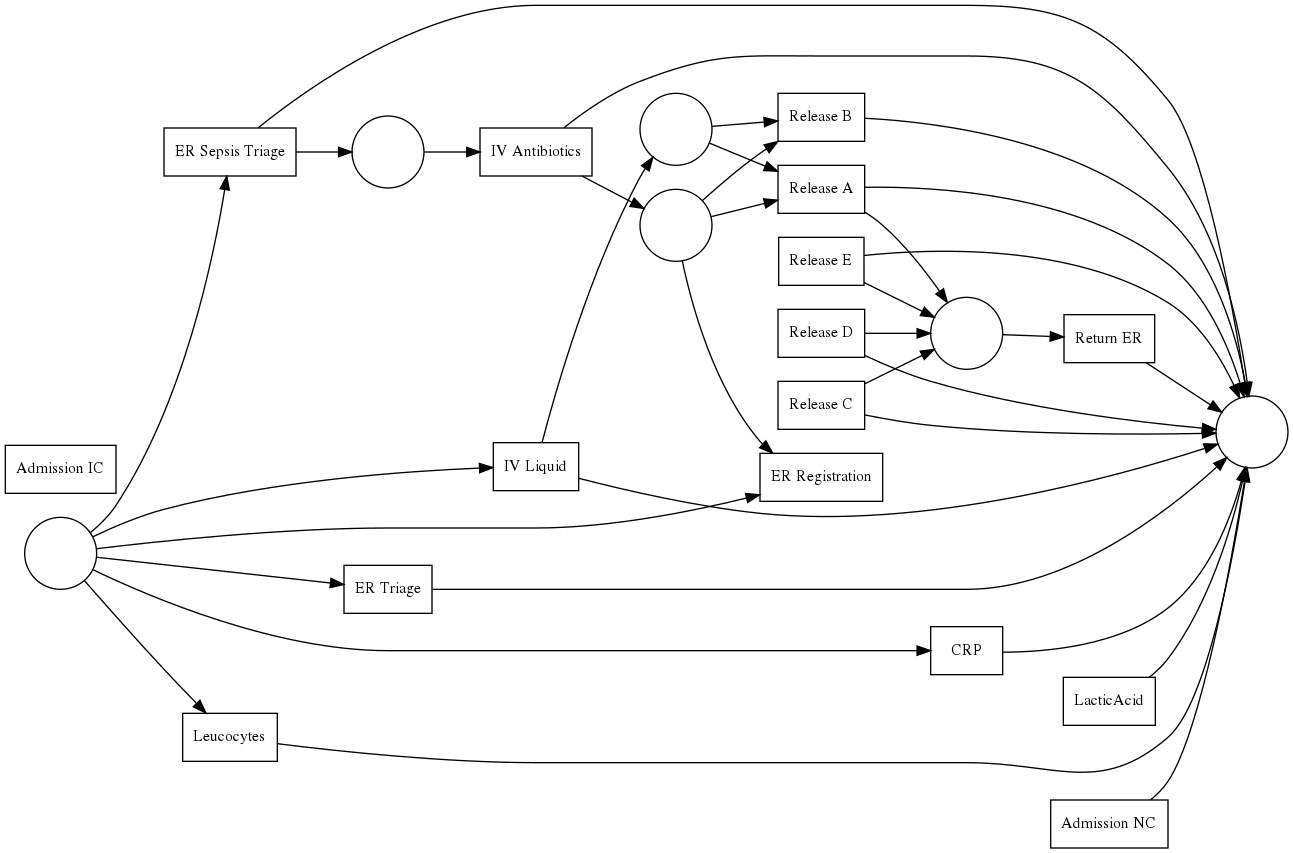

In [5]:
# create miner
am = AlphaMiner()

"""
Below there are several manually created dummy logs (copied from the book)
to test the algorithm. They can be passed on to the function call via the
variable 'dummy_log=dl1' and an empty string for the actual log file.
Alternatively, a regular log file can be passed on to the function.
"""

# dummy logs (miner can handle 1-3, but produces wrong net for log 4 (loop of one))
dl1 = [["a","b","c","d"],
       ["a","c","b","d"],
       ["a","e","d"]]
dl2 = [["a","c","e","g"],
       ["a","e","c","g"],
       ["b","d","f","g"],
       ["b","f","d","g"]]
dl3 = [["a","b","e","f"],
       ["a","b","e","c","d","b","f"],
       ["a","b","c","e","d","b","f"],
       ["a","b","c","d","e","b","f"],
       ["a","e","b","c","d","b","f"]]
dl4 = [["a","c"],
       ["a","b","c"],
       ["a","b","b","c"],
       ["a","b","b","b","b","c"]]

net, initial_marking, final_marking = am.apply_alpha_algorithm(log="sepsis.xes")
#net, initial_marking, final_marking = am.apply_alpha_algorithm(log="",dummy_log=dl4)

# visualize (TODO: create function for visualization)
gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

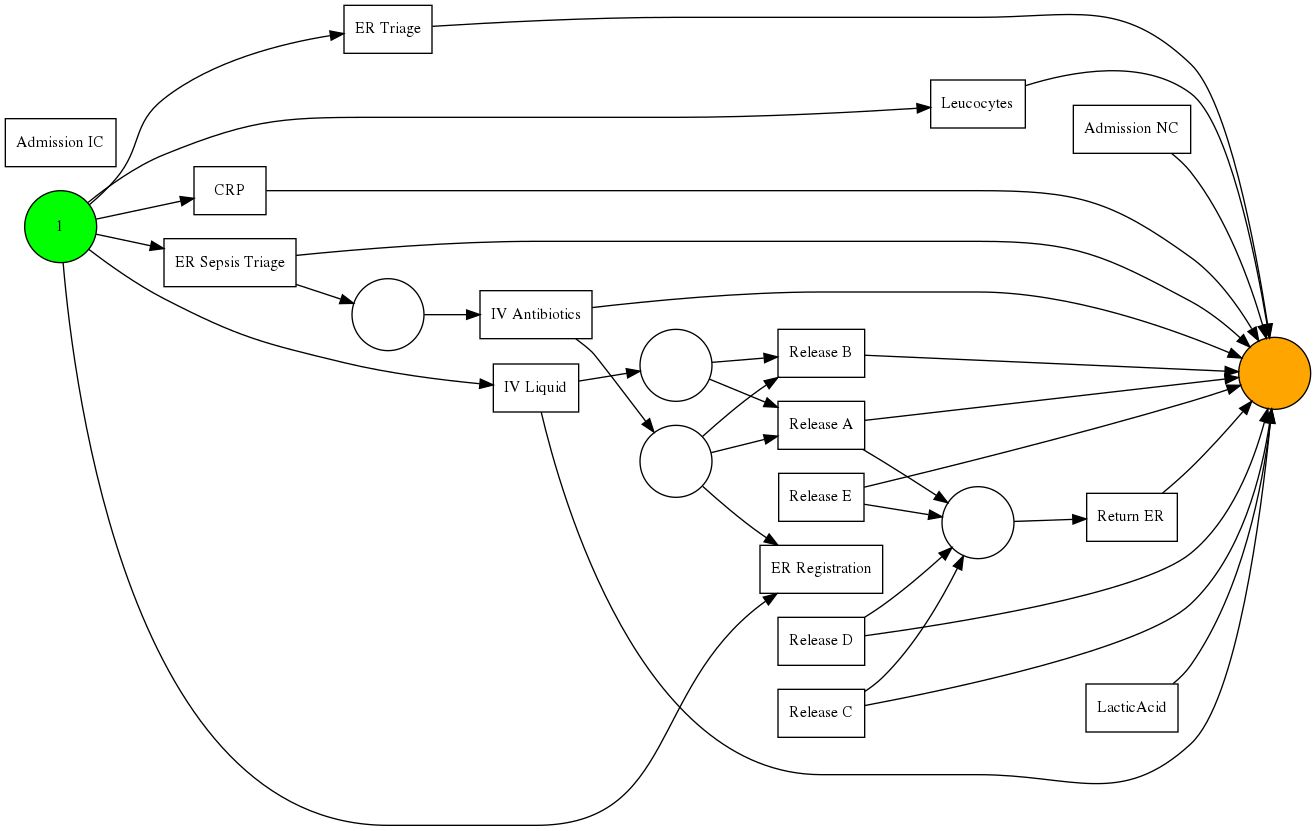

In [6]:
"""
Below, the pre-implemented pm4py AlphaMiner is applied to the same test log.
"""
log1 = xes_importer.apply("sepsis.xes")
net1, initial_marking1, final_marking1 = alpha_miner.apply(log1)

gviz1 = pn_visualizer.apply(net1, initial_marking1, final_marking1)
pn_visualizer.view(gviz1)